In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as gos
import plotly.figure_factory as ff
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## **Use and Remove Seasonality**

This is a cycle that repeats over time, such as monthly or yearly. This repeating cycle may obscure the signal that we wish to model when forecasting, and in turn may provide a strong signal to our predictive models.

**Seasonality in Time Series**

Seasonal variation, or seasonality, are cycles that repeat regularly over time.

A repeating pattern within each year is known as seasonal variation, although the term is applied more generally to repeating patterns within any fixed period.

*A cycle structure in a time series may or may not be seasonal. If it consistently repeats at the same frequency, it is seasonal, otherwise it is not seasonal and is called a cycle.*


**Benefits to Machine Learning**

Understanding the seasonal component in time series can improve the performance of modeling with machine learning. This can happen in two main ways:

- *Clearer Signal:* Identifying and removing the seasonal component from the time series can result in a clearer relationship between input and output variables.
- *More Information:* Additional information about the seasonal component of the time series can provide new information to improve model performance.


**Types of Seasonality**

There are many types of seasonality; for example:
- Time of Day.
- Daily.
- Weekly.
- Monthly.
- Yearly.

As such, identifying whether there is a seasonality component in your time series problem is subjective. The simplest approach to determining if there is an aspect of seasonality is to plot and review your data, perhaps at different scales and with the addition of trend lines.

**Removing Seasonality**

Once seasonality is identified, it can be modeled. The model of seasonality can be removed from the time series. This process is called Seasonal Adjustment, or Deseasonalizing. A time series where the seasonal component has been removed is called seasonal stationary. A time series with a clear seasonal component is referred to as non-stationary.

There are sophisticated methods to study and extract seasonality from time series in the field of Time Series Analysis. As we are primarily interested in predictive modeling and time series forecasting, we are limited to methods that can be developed on historical data and available when making predictions on new data. In this tutorial, we will look at two methods for making seasonal adjustments on a classical meteorological-type problem of daily temperatures with a strong additive seasonal component.


**Seasonal Adjustment with Differencing**

A simple way to correct for a seasonal component is to use differencing. If there is a seasonal component at the level of one week, then we can remove it on an observation today by subtracting the value from last week. In the case of the Minimum Daily Temperatures dataset, it looks like we have a seasonal component each year showing swing from summer to winter.

We can subtract the daily minimum temperature from the same day last year to correct for seasonality. This would require special handling of February 29th in leap years and would mean that the first year of data would not be available for modeling.

Text(0.5, 1.0, 'Line plot of the deseasonalized Minimum Daily Temperatures dataset using\ndifferencing.')

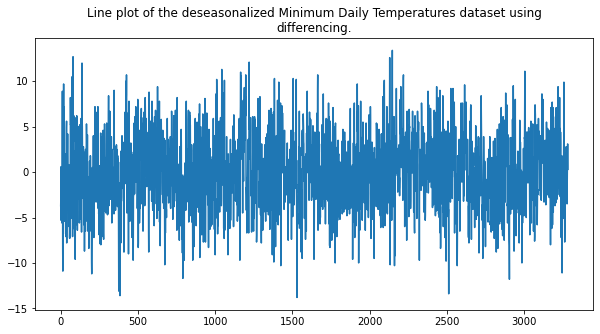

In [2]:
# deseasonalize a time series using differencing by days
series = pd.read_csv('daily-minimum-temperatures.csv', header=0,
                        index_col=0, parse_dates=True,squeeze=True)

X = series.values

diff = []

days_in_year = 365

for i in range(days_in_year, len(X)):
    value = X[i] - X[i- days_in_year]
    diff.append(value)

len(X) # 3650
len(diff) # 3285

fig,ax = plt.subplots(figsize=(10,5))
sns.lineplot(data=diff)
ax.set_title("""Line plot of the deseasonalized Minimum Daily Temperatures dataset using
differencing.""")

There are two leap years in our dataset (1984 and 1988). They are not explicitly handled; this means that observations in March 1984 onwards the offset are wrong by one day, and after March 1988, the offsets are wrong by two days. One option is to update the code example to be leap-day aware.

Another option is to consider that the temperature within any given period of the year is probably stable. Perhaps over a few weeks. We can shortcut this idea and consider all temperatures within a calendar month to be stable. An improved model may be to subtract the average temperature from the same calendar month in the previous year, rather than the same day. We can start off by resampling the dataset to a monthly average minimum temperature.

In [3]:
# Calculate and plot monthly average

resample = series.resample('M')
monthly_mean = resample.mean()

monthly_mean.head(13)

Date
1981-01-31    17.712903
1981-02-28    17.678571
1981-03-31    13.500000
1981-04-30    12.356667
1981-05-31     9.490323
1981-06-30     7.306667
1981-07-31     7.577419
1981-08-31     7.238710
1981-09-30    10.143333
1981-10-31    10.087097
1981-11-30    11.890000
1981-12-31    13.680645
1982-01-31    16.567742
Freq: M, Name: Temp, dtype: float64

In [7]:
len(monthly_mean)
# monthly_mean[12]

120

Text(0.5, 1.0, 'Example output of first 13 months of rescaled Minimum Daily Temperatures dataset.')

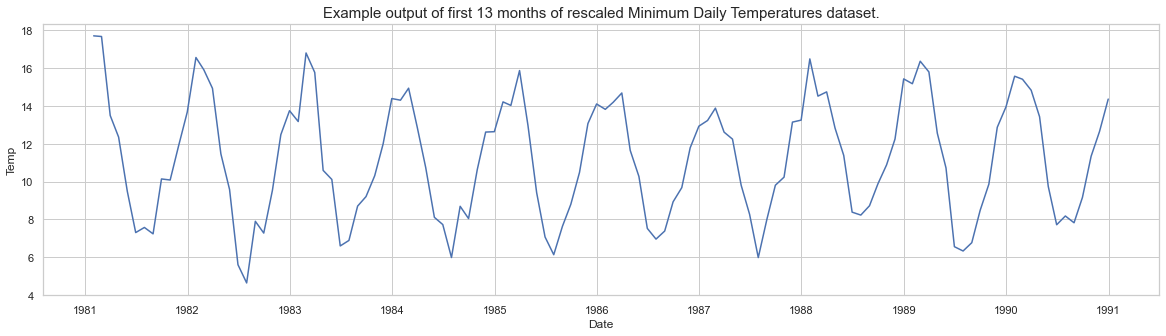

In [8]:
sns.set_theme(style="whitegrid")
fig,ax = plt.subplots(figsize=(20,5))
sns.lineplot(data=monthly_mean)
ax.set_title("""Example output of first 13 months of rescaled Minimum Daily Temperatures dataset.""", fontsize=15)

Text(0.5, 1.0, 'Line plot of the deseasonalized monthly Minimum Daily Temperatures dataset..')

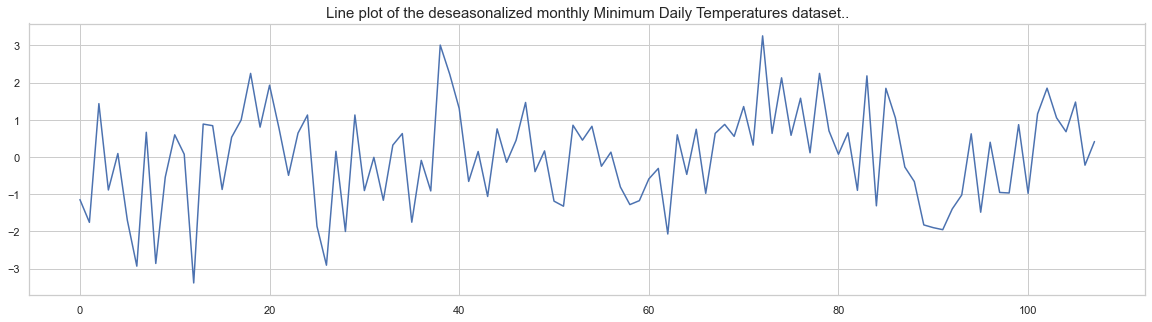

In [9]:
# deseasonalize monthly data by differencing

X = series.values
diff = []
months_in_year = 12
for i in range(months_in_year, len(monthly_mean)):
    value = monthly_mean[i] - monthly_mean[i -months_in_year]
    diff.append(value)

sns.set_theme(style="whitegrid")
fig,ax = plt.subplots(figsize=(20,5))
sns.lineplot(data=diff)
ax.set_title("""Line plot of the deseasonalized monthly Minimum Daily Temperatures dataset..""", fontsize=15)

**Seasonal Adjustment with Modeling**

We can model the seasonal component directly, then subtract it from the observations. The seasonal component in a given time series is likely a sine wave over a generally fixed period and amplitude. This can be approximated easily using a curve-fitting method. A dataset can be constructed with the time index of the sine wave as an input, or x-axis, and the observation as the output, or y-axis.

Once fit, the model can then be used to calculate a seasonal component for any time index. In the case of the temperature data, the time index would be the day of the year. We can then estimate the seasonal component for the day of the year for any historical observations or any new observations in the future. The curve can then be used as a new input for modeling with supervised learning algorithms, or subtracted from observations to create a seasonally adjusted series.

Let's start off by fitting a curve to the Minimum Daily Temperatures dataset. The NumPy library provides the polyfit() function that can be used to fit a polynomial of a chosen order to a dataset. First, we can create a dataset of time index (day in this case) to observation. We could take a single year of data or all the years. Ideally, we would try both and see which model resulted in a better fit. We could also smooth the observations using a moving average centered on each value. This too may result in a model with a better fit. 

Once the dataset is prepared, we can create the fit by calling the polyfit() function passing the x-axis values (integer day of year), y-axis values (temperature observations), and the order of the polynomial. The order controls the number of terms, and in turn the complexity of the curve used to fit the data. Ideally, we want the simplest curve that describes the seasonality of the dataset. For consistent sine wave-like seasonality, a 4th order or 5th order polynomial will be sufficient. In this case, I chose an order of 4 by trial and error. The resulting model takes the form:

$\ y = (x^4 * b_1) + (x^3 * b_2) + (x^2 * b_3) + (x^1 * b_4) + b_5  $

Where: 
- y is the fit value, 
- x is the time index (day of the year), 
- b1 to b5 are the coefficients found by the curve-fitting optimization algorithm. 

Once fit, we will have a set of coefficients that represent our model. We can then use this model to calculate the curve for one observation, one year of observations, or the entire dataset.

In [36]:
# model seasonality with a polynomial model

series = pd.read_csv('daily-minimum-temperatures.csv', header=0,
                        index_col=0, parse_dates=True,squeeze=True)

# fit polynomial x^2*b1 + x*b2 + ... + bn

X = [i%365 for i in range(0,len(series))]
y = series.values
degree = 4
coef = np.polyfit(X,y,degree)

coef
# len(X) # 3650
# len(y) # 3650

array([-1.17308000e-08,  9.30253946e-06, -2.15977594e-03,  1.19147966e-01,
        1.38980178e+01])

In [41]:
X[0]

0

In [42]:
len(series)

3650

In [47]:
# For understanding the use of % above; "%" returns the remainder
0%365

0

In [48]:
curve = []

for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)

curve[50] # The 50th day is somewhat the peek

15.545476162584702

In [49]:
len(curve)

3650

Text(0.5, 1.0, 'Line plot of the Minimum Daily Temperatures dataset (blue) and a nonlinear model of the seasonality (red).')

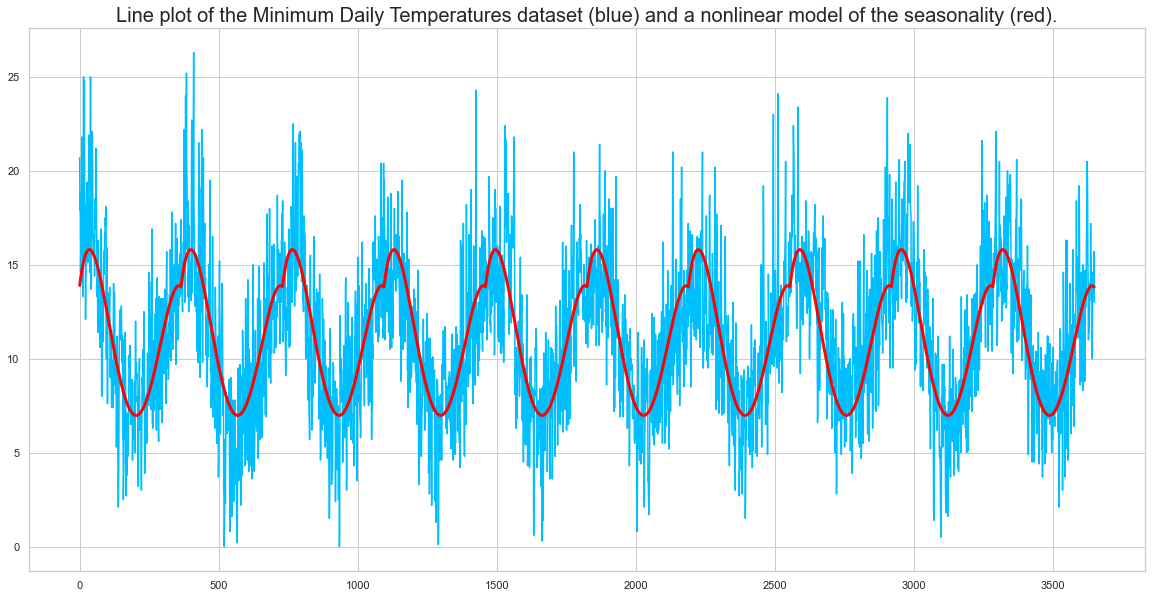

In [51]:
# plot curve over original data 
fig,ax= plt.subplots(figsize=(20,10))
sns.lineplot(data=series.values,color='deepskyblue')
sns.lineplot(data=curve,color="red",linewidth=3,alpha=6)
ax.set_title("""Line plot of the Minimum Daily Temperatures dataset (blue) and a nonlinear model of the seasonality (red).""", fontsize=20)

The curve appears to be a good fit for the seasonal structure in the dataset. We can now use this model to create a seasonally adjusted version of the dataset.

In [52]:
# model seasonality with a polynomial model

series = pd.read_csv('daily-minimum-temperatures.csv', header=0,
                        index_col=0, parse_dates=True,squeeze=True)

# fit polynomial x^2*b1 + x*b2 + ... + bn

X = [i%365 for i in range(0,len(series))]
y = series.values
degree = 4
coef = np.polyfit(X,y,degree)

coef

# The curve
curve = []

for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)

curve[50] # The 50th day is somewhat the peek

# create seasonally adjusted
values = series.values
diff = []

for i in range(len(values)):
    value = values[i] - curve[i]
    diff.append(value)

len(diff)

3650

Text(0.5, 1.0, 'Line plot of the deseasonalized Minimum Daily Temperatures dataset using a nonlinear model.')

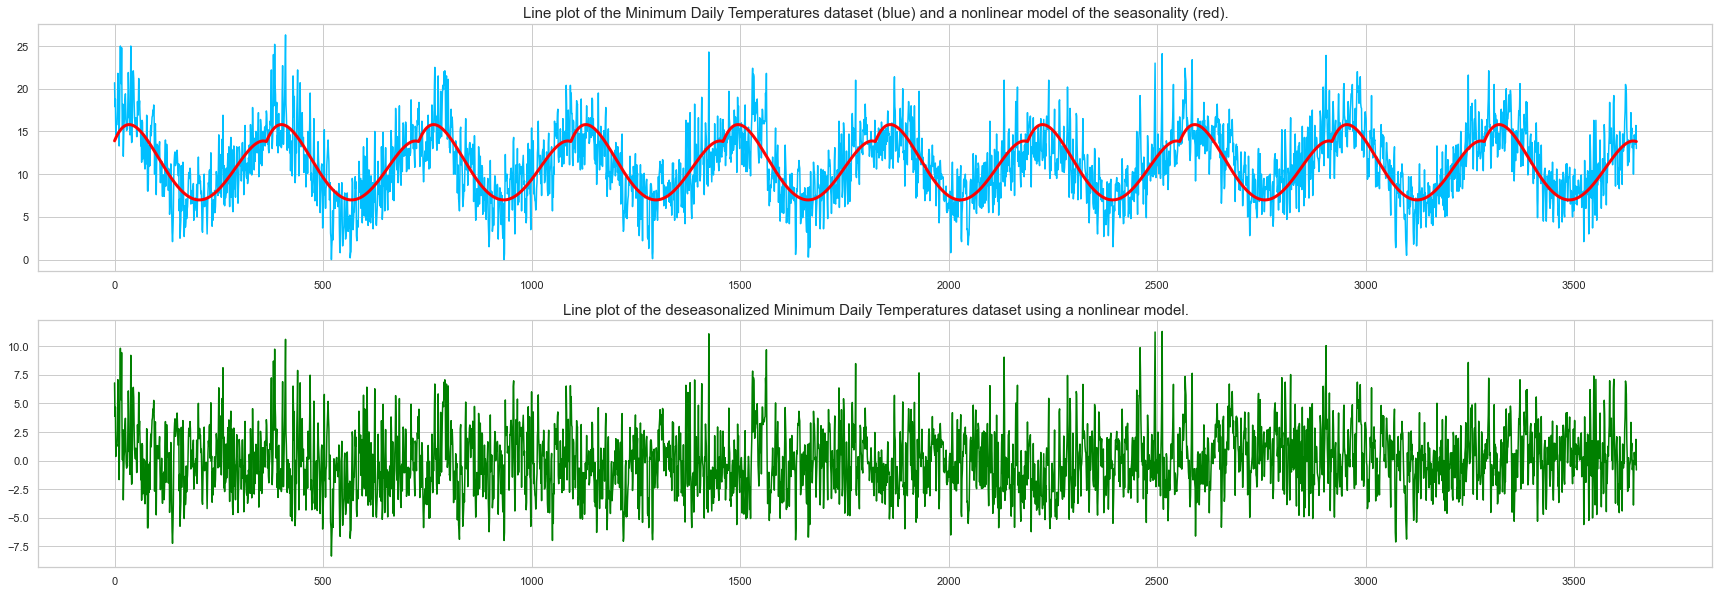

In [53]:
# plot curve over original data 

fig,ax= plt.subplots(2,1, figsize=(30,10))
# ax = ax.ravel()
plot1 = sns.lineplot(data=series.values,color='deepskyblue',ax =ax[0])
plot2 = sns.lineplot(data=curve,color="red",linewidth=3,alpha=6,ax =ax[0])
plot1.set_title("""Line plot of the Minimum Daily Temperatures dataset (blue) and a nonlinear model of the seasonality (red).""", fontsize=15)



# plot4 = 

plot3 = sns.lineplot(data=diff,color='green',ax =ax[1])
plot3.set_title("""Line plot of the deseasonalized Minimum Daily Temperatures dataset using a nonlinear model.""", fontsize=15)